In [1]:
import os
import itertools
import numpy as np; print('numpy:', np.__version__)
import scipy as sp; print('scipy:', sp.__version__)
from scipy import fft
import h5py as hdf; print('h5py:', hdf.__version__)
import matplotlib as mpl; print('matplotlib:', mpl.__version__)
from matplotlib import pyplot as plt

numpy: 1.22.3
scipy: 1.8.0
h5py: 3.6.0
matplotlib: 3.5.1


In [2]:
#prefix = 'result/230221_fp64'
#prec = 'double'
#xyprune, step = 32, 13600
#xyprune, step = 16, 40000 ## lambda_i
prefix = 'result/230221_fp32'
prec = 'float'
#xyprune, step = 16, 9800 ## @rloc2, M = 4 dies
#xyprune, step = 32, 5400 ## M = 4 dies
xyprune, step = 64, 3200 ## M = 16 dies
os.makedirs(f'{prefix}/fig', exist_ok=True)
nx = 256
Nee = [4, 16, 64]
Ne0 = Nee[0]
n_batch = nx*nx

Z: (256, 256, 4, 4)


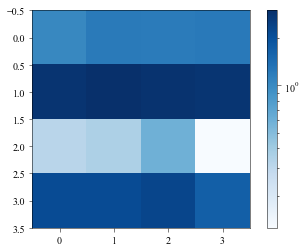

In [3]:
## hdf loader
def load_mat(prefix=prefix, Ne=Ne0, name='_Z', prec=prec, ncol=None, nrow=None, nx=nx, xyprune=xyprune, step=step, verbose=False,):
    if ncol is None:
        ncol = Ne
    if nrow is None:
        nrow = Ne
    ny = nx // Ne
    arr_merged = np.nan * np.zeros( (ny*Ne, nx, ncol, nrow) )
    for iens in range(Ne):
        #with hdf.File(f'{prefix}/ens{Ne}/xyprune{xyprune}/errrho_0.01_erru0.1/beta_opt/io_letkf/letkf/mat/ens{iens}/{name}.{prec}_{nrow}_{ncol}_{nx*ny}.{step}.h5', 'r') as f:
        with hdf.File(f'{prefix}/ens{Ne}/xyprune{xyprune}/io_letkf/letkf/mat/ens{iens}/{name}.{prec}_{nrow}_{ncol}_{nx*ny}.{step}.h5', 'r') as f:
            if verbose:
                print(f['data'])
            arr = f['data'][...]
            arr = arr.reshape((ny, nx, ncol, nrow))
            if verbose:
                print('np array reshaped:', arr.shape)
            arr_merged[iens*ny:(iens+1)*ny, ...] = arr[...]
    return arr_merged
    
def test():
    Z = load_mat()
    print('Z:', Z.shape)
    ## test plot heatmap
    mat = load_mat()
    plt.imshow(
        np.abs(mat[0, 0, :, :]).T,
        cmap = 'Blues',
        norm = mpl.colors.LogNorm()
    )
    plt.colorbar()
    plt.show()

try:
    test()
except:
    pass

In [4]:
def sub(name, tag, *, show_ratio=False, nrow=None, ncol=None, irow=None, icol=None, Nee=Nee, vmin=None, vmax=None):
    ## FFT
    def fft_abs(Ne, nx=nx, nrow=nrow, ncol=ncol, verbose=False):
        print(f'{name}: Ne = {Ne},', 
              f'irow = {irow},' if irow is not None else '',
              f'icol = {icol},' if icol is not None else '',
             )
        Z = load_mat(Ne=Ne, name=name, nrow=nrow, ncol=ncol)
        if nrow is None:
            nrow = Ne
        if ncol is None:
            ncol = Ne
        irange = np.arange(nrow) if irow is None else [irow]
        jrange = np.arange(ncol) if icol is None else [icol]
        krange = np.arange(nx)
        zij = np.zeros((nx, nx), dtype=np.float128)
        kk = np.arange(nx//2)
        zk = np.zeros_like(kk, dtype=np.float128)
        for i,j in itertools.product(irange, jrange): ## loop for row-column of Z
            print(f'\r({i:2d}, {j:2d}) / ({nrow:2d}, {ncol:2d})', end='')
            zij[:, :] = Z[:, :, j, i]
            zij_fft = fft.fft2(zij) / nx / nx / Ne
            for kx, ky in itertools.product(krange, krange): ## loop for sum_k |Z(k)|
                k = int((kx**2 + ky**2)**0.5 + 0.5)
                if k < nx//2:
                    zk[k] += np.abs(zij_fft[kx, ky])
        print()
        if verbose:
            plt.plot(kk, zk)
            plt.loglog()
            plt.show()
            plt.close()
        return kk, zk
        
    ne = []
    k = []
    zk = []
    for ne_ in Nee:
        k_, zk_ = fft_abs(ne_)
        ne.append(ne_)
        k.append(k_)
        zk.append(zk_)
        
    fig, ax = plt.subplots()
    for ne_, k_, zk_ in zip(ne, k, zk):
        ax.plot(k_, zk_, label=rf'$M$={ne_}')
    
    ax.set_xscale('log')
    ax.set_xlim(1,nx//2)
    ax.set_yscale('log')
    ax.set_ylim(vmin, vmax)
    ax.set_xlabel(r'$k$')
    ax.set_ylabel(rf'|{tag}$(k)$|')
    ax.legend()
    icolstr = f'_icol{icol}' if icol is not None else ''
    fname = f'{prefix}/fig/letkf_matrix_{name}_xyprune{xyprune}{icolstr}.pdf'
    plt.savefig(fname, bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)
    
    if show_ratio:
        fig, ax = plt.subplots()
        zk64 = zk[-1]
        for ne_, k_, zk_ in zip(ne[:-1], k[:-1], zk[:-1]):
            zkzk64_ = np.divide(zk_, zk64, out=np.zeros_like(zk_), where=zk64!=0)
            ax.plot(k_, zk_ / zk64, label=rf'$M$={ne_}')
    
        ax.set_xscale('log')
        ax.set_xlim(1,nx//2)
        ax.set_yscale('log')
        ax.set_xlabel(r'$k$')
        ax.set_ylabel(rf'{tag}$(k)$ / {tag}$_{64}(k)$')
        ax.legend()
        icolstr = f'_icol{icol}' if icol is not None else ''
        fname = f'{prefix}/fig/letkf_matrix_{name}_r64_xyprune{xyprune}{icolstr}.pdf'
        plt.savefig(fname, bbox_inches='tight')
        plt.show(fig)
        plt.close(fig)

if False:
    sub('_Xf', r'$X^\mathrm{f}$', nrow=9)
    sub('_Xa', r'$X^\mathrm{a}$', nrow=9)
    sub('_Wa', r'$W^\mathrm{a}$')
    sub('_V', r'$V_\mathrm{eig}$')
    sub('_Lambda', r'$\lambda_\mathrm{eig}$')
    sub('_Wa', r'$W^\mathrm{a}$')
    sub('_Wma', r'$\bar{w}^\mathrm{a}$')
    sub('_dXf', r'$\delta X^\mathrm{f}$', nrow=9)
    sub('_dYf', r'$\delta Y^\mathrm{f}$', nrow=48)
if False:
    sub('_Q', r'$Q$')
    sub('_Pa', r'$\tilde{P}^\mathrm{a}$')
    sub('_dWa', r'$\delta W^\mathrm{a}$')
    sub('_Z', r'$\Omega$')
    
if False:
    sub('_AI', r'$\Delta$', nrow=9)
    
if False:
    Ne_ = 64
    for i in range(64):
        kwargs = dict(icol = i, Nee = [Ne_], show_ratio = False, vmin=1e-3, vmax=1e-1)
        Lambda = load_mat(Ne=Ne_, name='_Lambda')
        print(f'lambda_{i} = {np.mean(Lambda[:, :, i, i])}')
        #sub('_Lambda', r'$\lambda_\mathrm{eig}$', **kwargs)
        sub('_V', r'$V_\mathrm{eig}$', **kwargs)

if False:
    print('.')
    Ne_ = 64
    fname = f'{prefix}/fig/letkf_lambda_{Ne_}.csv'
    with open(fname, 'w') as f:
        print('i,lambda', file=f)
    for i in range(64):
        Lambda = load_mat(Ne=Ne_, name='_Lambda')
        with open(fname, 'a') as f:
            l = np.mean(Lambda[:, :, i, i])
            print(f'{i},{l:.15g}', file=f)
            print(f'{i},{l:.15g}')

_AI
iens =  3 /  4
iens = 15 / 16
iens = 63 / 64


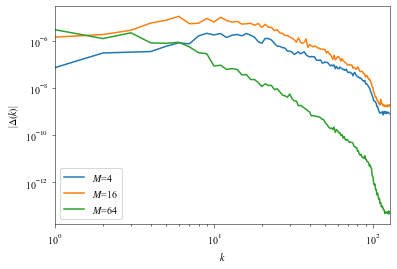

In [5]:
## fft of AI, Xa, Xf, tranformed to velocity |Δ(k)| = 1/2 |{ua - uf}(k)|^2

## name0 should be Xf; used for calculate rho(x,y)

def sub(name, tag, *, name0='_Xf', show_ratio=False, Nee=Nee, vmin=None, vmax=None):
    ## bc
    nrow = 9
    ncol = None ## ncol is equivalent to ensemble size
    
    print(name)
    
    ## FFT
    def fft_abs(Ne, nx=nx, nrow=nrow, ncol=ncol, verbose=False):
        LBM = load_mat(Ne=Ne, name=name, nrow=nrow, ncol=ncol)
        LBM0 = load_mat(Ne=Ne, name=name0, nrow=nrow, ncol=ncol)
        ncol = Ne
        qrange = np.arange(nrow)
        mrange = np.arange(ncol)
        krange = np.arange(nx)
        kk = np.arange(nx//2)
        ek = np.zeros_like(kk, dtype=np.float128)

        for m in mrange: ## loop for row-column of Z
            print(f'\riens = {m:2d} / {ncol:2d}', end='')
            ## LBM(x, y) to u(x, y), v(x, y)
            r = np.zeros((nx, nx))
            f0 = np.zeros((nx, nx))
            du = np.zeros((nx, nx))
            dv = np.zeros((nx, nx))
            df = np.zeros((nx, nx))
            for q in qrange:
                ey = lambda q: q//3 - 1
                ex = lambda q: q %3 - 1
                f0[:, :] = LBM0[:, :, m, q]
                df[:, :] = LBM [:, :, m, q]
                r[:, :] += f0[:, :]
                du[:, :] += ex(q) * df[:, :]
                dv[:, :] += ey(q) * df[:, :]
            du[:, :] = du[:, :] / r[:, :]
            dv[:, :] = dv[:, :] / r[:, :]
                
            ## fft;
            ## u(x, y) --> u(kx, ky), v(x, y) --> v(kx, ky)
            ## ffte(kx, ky) = 1/2 (uu(kx, ky) + vv(kx, ky))
            fftu = fft.fft2(du) / nx / nx
            fftv = fft.fft2(dv) / nx / nx
            ffte = (fftu**2 + fftv**2)/2
    
            ## shell average; e(kx, ky) --> e(k)
            for ki,kj in itertools.product(krange, krange):
                k = int(np.sqrt(ki**2 + kj**2) + 0.5)
                if k <= np.max(kk):
                    ek[k] += np.abs(ffte[ki,kj])
                                
        ## finally, get ensemble mean of
        ek /= Ne
        
        print()
        if verbose:
            plt.plot(kk, ek)
            plt.loglog()
            plt.show()
            plt.close()
        return kk, ek
        
    ne = []
    k = []
    zk = []
    for ne_ in Nee:
        k_, zk_ = fft_abs(ne_)
        ne.append(ne_)
        k.append(k_)
        zk.append(zk_)
        
    fig, ax = plt.subplots()
    for ne_, k_, zk_ in zip(ne, k, zk):
        ax.plot(k_, zk_, label=rf'$M$={ne_}')
    
    ax.set_xscale('log')
    ax.set_xlim(1,nx//2)
    ax.set_yscale('log')
    ax.set_ylim(vmin, vmax)
    ax.set_xlabel(r'$k$')
    ax.set_ylabel(rf'|{tag}$(k)$|')
    ax.legend()
    fname = f'{prefix}/fig/letkf_matrix_{name}_at_energy_xyprune{xyprune}.pdf'
    plt.savefig(fname, bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)
    
    if show_ratio:
        fig, ax = plt.subplots()
        zk64 = zk[-1]
        for ne_, k_, zk_ in zip(ne[:-1], k[:-1], zk[:-1]):
            zkzk64_ = np.divide(zk_, zk64, out=np.zeros_like(zk_), where=zk64!=0)
            ax.plot(k_, zk_ / zk64, label=rf'$M$={ne_}')
    
        ax.set_xscale('log')
        ax.set_xlim(1,nx//2)
        ax.set_yscale('log')
        ax.set_xlabel(r'$k$')
        ax.set_ylabel(rf'{tag}$(k)$ / {tag}$_{64}(k)$')
        ax.legend()
        icolstr = f'_icol{icol}' if icol is not None else ''
        fname = f'{prefix}/fig/letkf_matrix_{name}_at_energy_r64_xyprune{xyprune}{icolstr}.pdf'
        plt.savefig(fname, bbox_inches='tight')
        plt.show(fig)
        plt.close(fig)

if True:
    sub('_AI', r'$\Delta$')
    
if False:
    sub('_Xf', r'$X^\mathrm{f}$')
    sub('_Xa', r'$X^\mathrm{a}$')
    sub('_dXf', r'$\delta X^\mathrm{f}$')